In [2]:
import sys
sys.path.append('../../')

In [3]:
#import importlib
#import src
#importlib.reload(src.utils.read_tif)

In [9]:
#%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
from src.utils.utils import get_patch_name_from_prediction_name

In [7]:
from src.utils.read_tif import acquire_data, tif_2_rgb, tif_2_fdi, tif_2_ndvi, tif_2_swir
from src.utils.utils import get_tile_name_from_prediction_name, get_patch_name_from_prediction_name

In [8]:
seed = 0
folder_predictions = "../../data/predicted_unet/"
folder_input_images = "../../data/patches/"
tif_ext = ".tif"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_0_unet.tif________________________________________


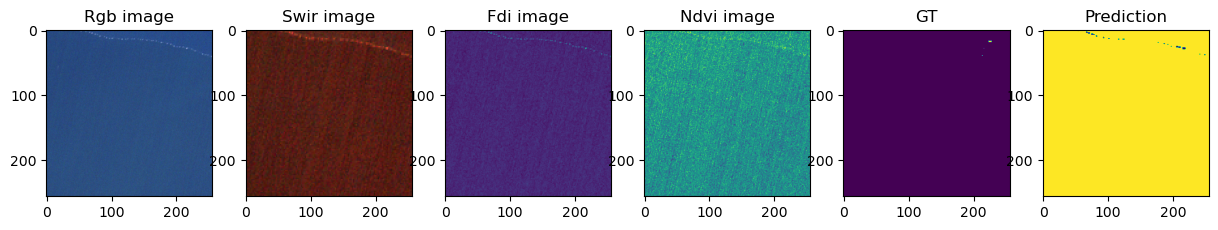

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_1_unet.tif________________________________________


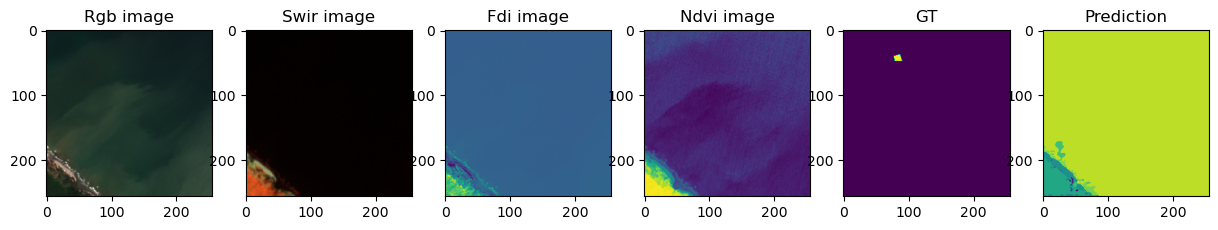

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_10_unet.tif________________________________________


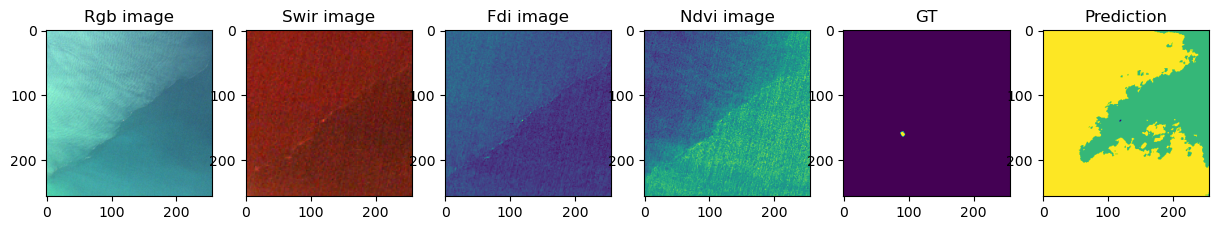

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_12_unet.tif________________________________________


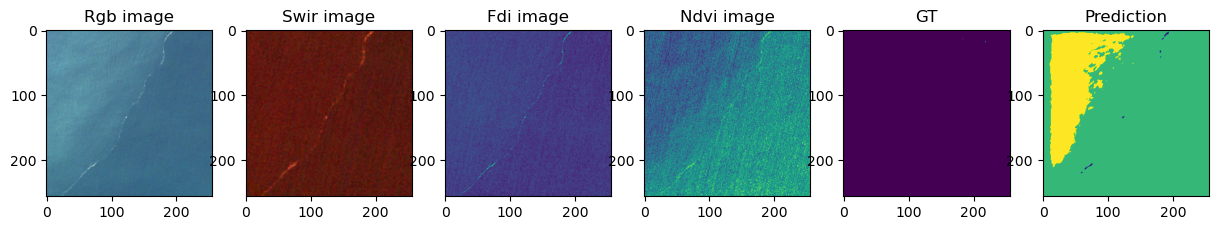

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_17_unet.tif________________________________________


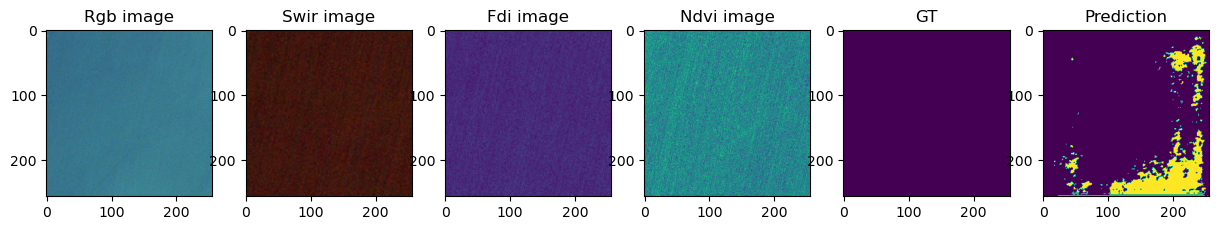

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_13_unet.tif________________________________________


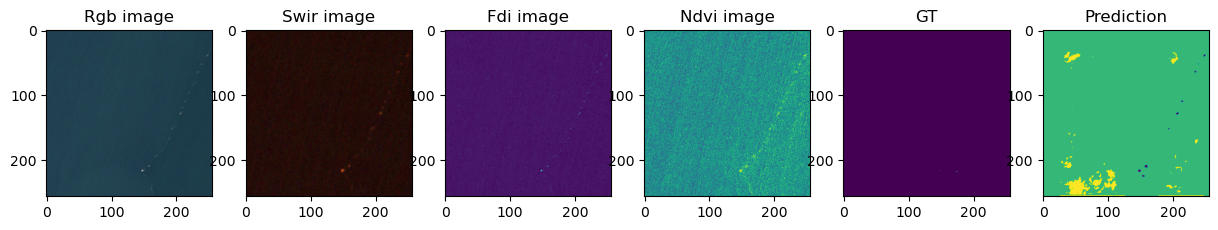

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_14_unet.tif________________________________________


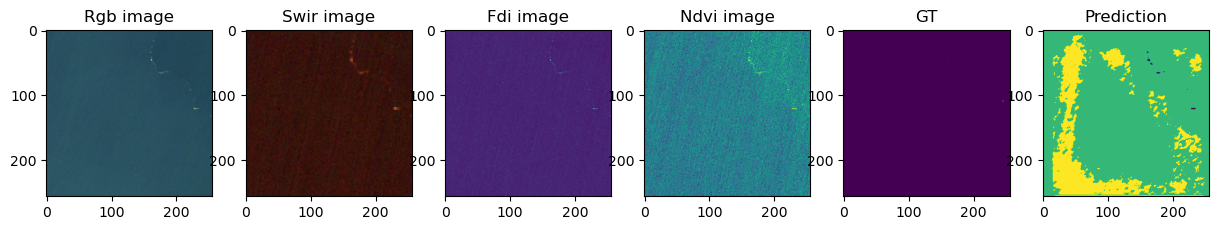

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_21_unet.tif________________________________________


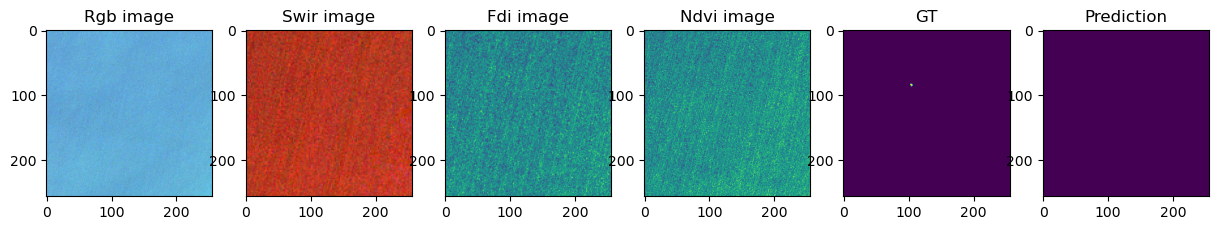

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_16_unet.tif________________________________________


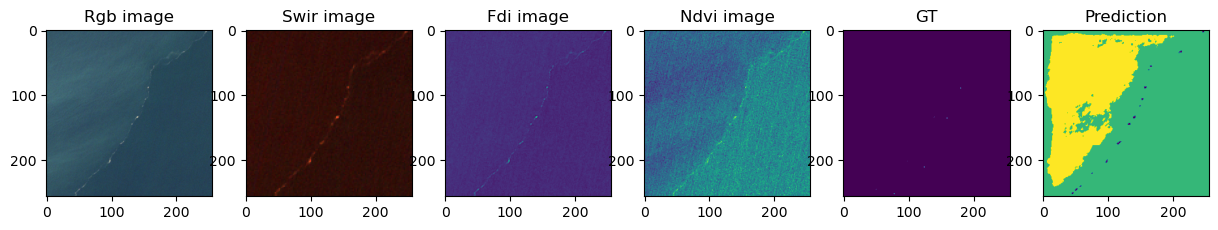

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_23_unet.tif________________________________________


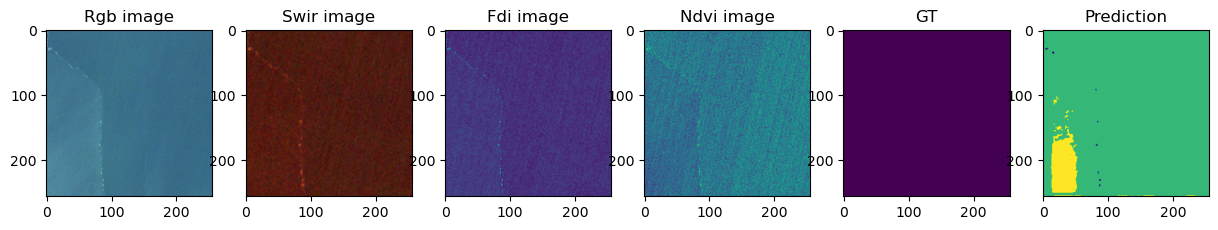

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


________________________________________S2_12-12-20_16PCC_24_unet.tif________________________________________


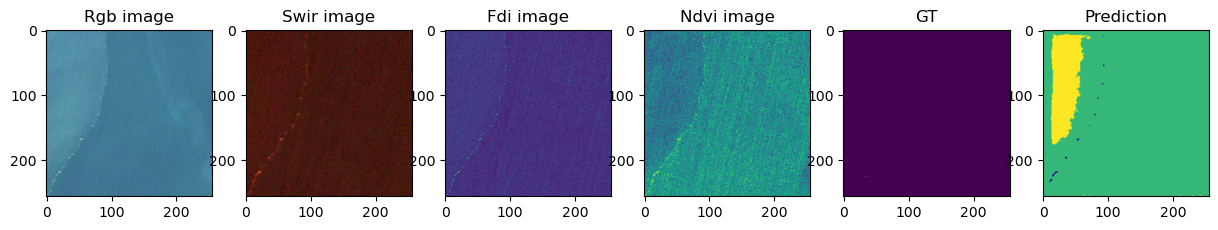

In [10]:
i = 0

for file_name in os.listdir(folder_predictions):
    index_sub_plot = 0
    tile_name = get_tile_name_from_prediction_name(file_name)
    patch_name = get_patch_name_from_prediction_name(file_name)
    f, axarr = plt.subplots(1, 6, figsize=(15, 5))
    
    
    # Plot rgb image
    tif_path = folder_input_images + tile_name + "/" + patch_name + tif_ext
    img_rgb = tif_2_rgb(tif_path)
    axarr[index_sub_plot].set_title("Rgb image")
    axarr[index_sub_plot].imshow(img_rgb)
    index_sub_plot += 1
    # Plot swir image
    tif_path = folder_input_images + tile_name + "/" + patch_name + tif_ext
    img_rgb = tif_2_swir(tif_path)
    axarr[index_sub_plot].set_title("Swir image")
    axarr[index_sub_plot].imshow(img_rgb)
    index_sub_plot += 1
    # Plot fdi image
    tif_path = folder_input_images + tile_name + "/" + patch_name + tif_ext
    img_rgb = tif_2_fdi(tif_path)
    axarr[index_sub_plot].set_title("Fdi image")
    axarr[index_sub_plot].imshow(img_rgb)
    index_sub_plot += 1
    # Plot ndvi image
    tif_path = folder_input_images + tile_name + "/" + patch_name + tif_ext
    img_rgb = tif_2_ndvi(tif_path)
    axarr[index_sub_plot].set_title("Ndvi image")
    axarr[index_sub_plot].imshow(img_rgb)
    index_sub_plot += 1
    # Plot semantic segmentation map
    tif_path = folder_input_images + tile_name + "/" + patch_name + "_cl" + tif_ext
    img_pred, _ = acquire_data(tif_path)
    axarr[index_sub_plot].set_title("GT")
    axarr[index_sub_plot].imshow(img_pred)
    index_sub_plot += 1
    # Plot prediction
    path = folder_predictions + file_name
    img_pred, _ = acquire_data(path)
    axarr[index_sub_plot].set_title("Prediction")
    axarr[index_sub_plot].imshow(img_pred)
    
    print("_" * 40 + f"{file_name}"+ "_" * 40)

    plt.show()
    
    i += 1
    if i > 10:
        break

In [5]:
import os
import ast
import sys
import json
import random
import logging
import argparse
import numpy as np
from tqdm import tqdm
from os.path import dirname as up

import torch
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

from src.semantic_segmentation.unet.dataloader import (
    GenDEBRIS,
    bands_mean,
    bands_std,
    RandomRotationTransform,
    class_distr,
    gen_weights,
)


def seed_all(seed):
    # Pytorch Reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def seed_worker(worker_id):
    # DataLoader Workers Reproducibility
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_all(0)
g = torch.Generator()
g.manual_seed(0)

# Transformations

transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        RandomRotationTransform([-90, 0, 90, 180]),
        transforms.RandomHorizontalFlip(),
    ]
)

transform_test = transforms.Compose([transforms.ToTensor()])

standardization = transforms.Normalize(bands_mean, bands_std)


dataset_train = GenDEBRIS(
    "train",
    transform=transform_train,
    standardization=standardization,
    agg_to_water=True,
    path="/data/marine-debris.github.io/data"
)


train_loader = DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    prefetch_factor=True,
    persistent_workers=True,
    worker_init_fn=seed_worker,
    generator=g,
)

Load train set to memory: 100%|██████████| 694/694 [00:07<00:00, 86.88it/s]


In [28]:
def s2_2_rgb(s2_img: str) -> np.ndarray:
    img_b = s2_img[:, :, 1].reshape(s2_img.shape[0], s2_img.shape[1], 1)
    img_g = s2_img[:, :, 2].reshape(s2_img.shape[0], s2_img.shape[1], 1)
    img_r = s2_img[:, :, 3].reshape(s2_img.shape[0], s2_img.shape[1], 1)

    img_rgb = np.concatenate((img_r, img_g, img_b), 2)
    img_rgb = img_rgb / img_rgb.max()
    return img_rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  4  6]


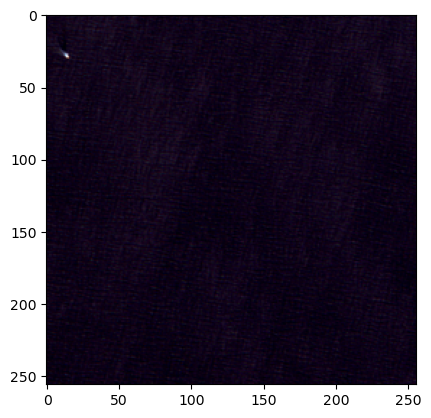

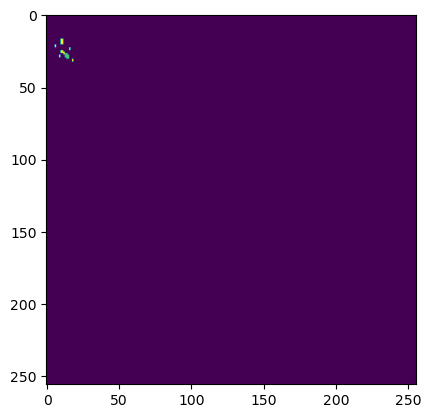

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  0  6]


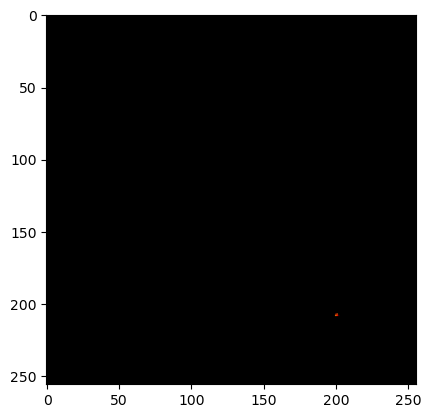

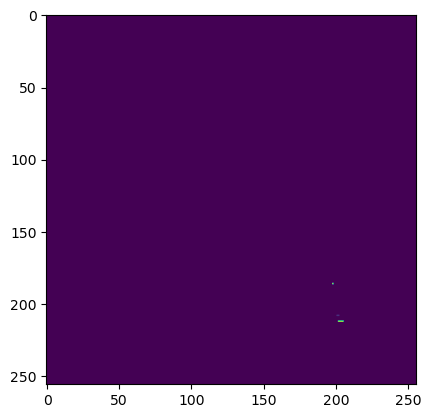

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  9]


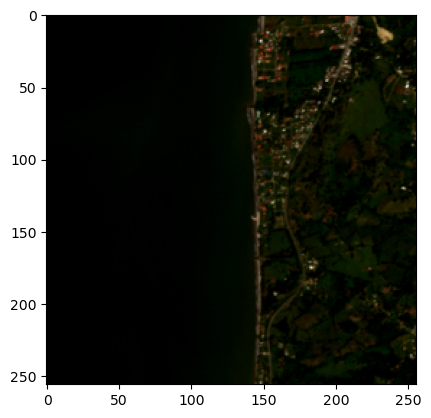

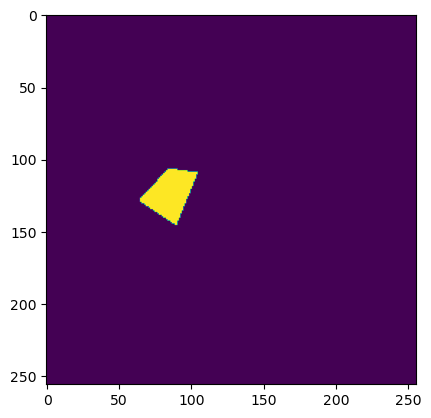

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  7  9]


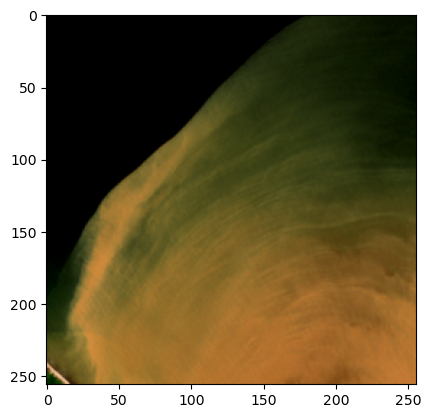

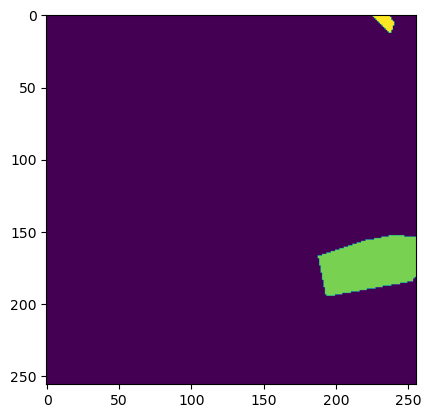

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  0  6]


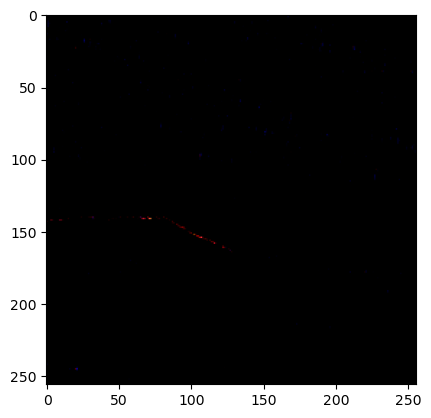

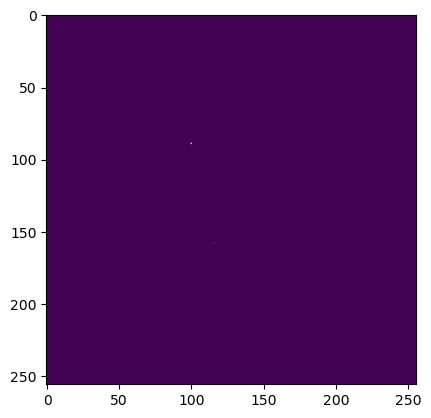

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  0  6]


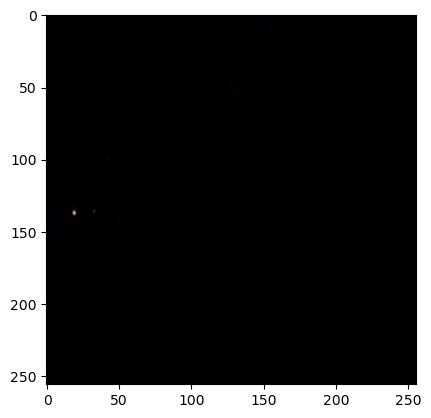

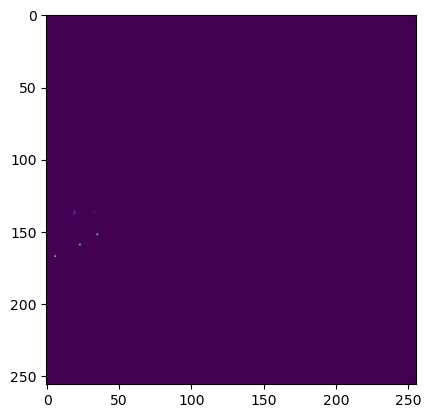

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  6 10]


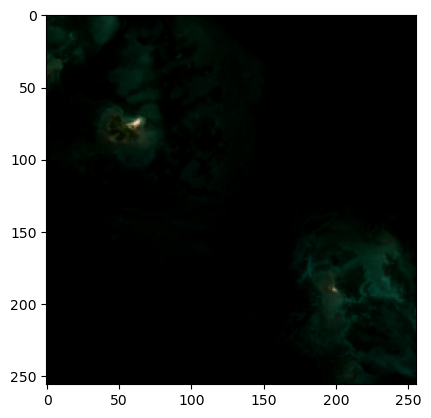

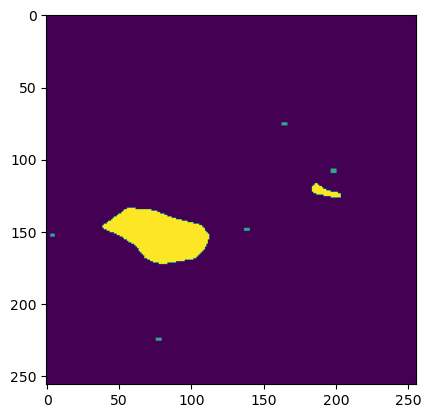

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  0  6]


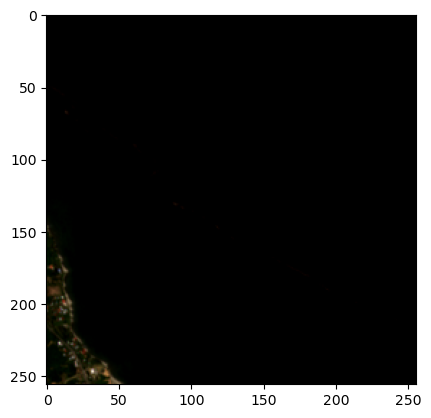

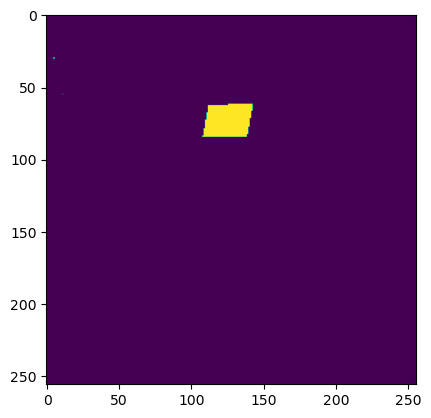

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  6]


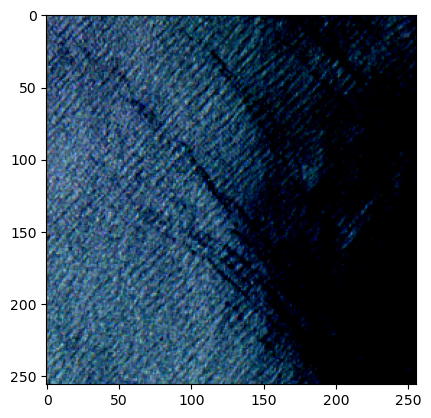

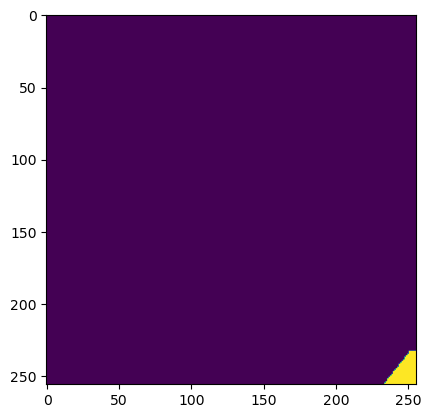

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  4  6]


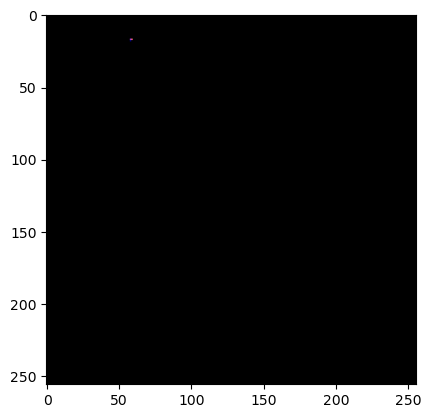

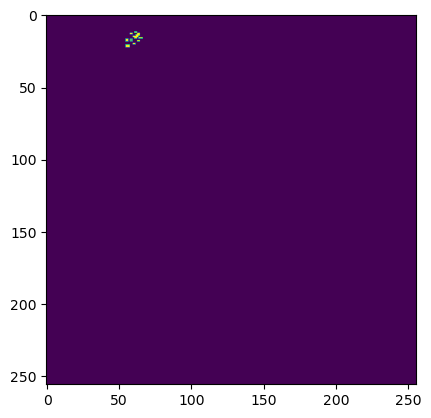

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([11, 256, 256])
(256, 256, 11)
[-1  6]


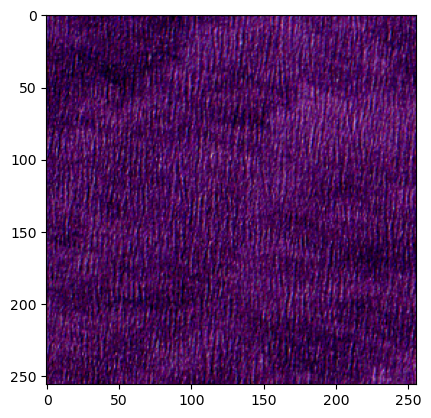

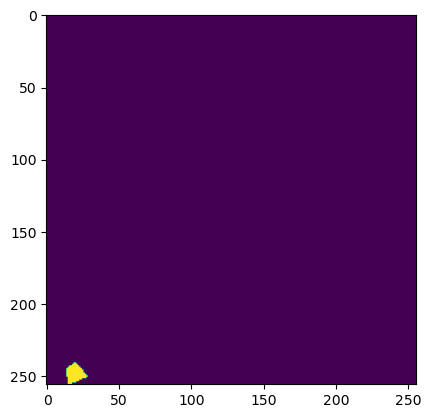

In [32]:
j = 0
n = 10
for img, target in train_loader:
    img = img[0]
    print(img.shape)
    img = np.array(img)
    img = np.moveaxis(img, 0, -1)
    print(img.shape)
    j += 1
    rgb_img = s2_2_rgb(img)
    print(np.unique(target))
    plt.imshow(rgb_img)
    plt.show()
    plt.imshow(target[0])
    plt.show()
    if j > n:
        break

array([-1, 10])

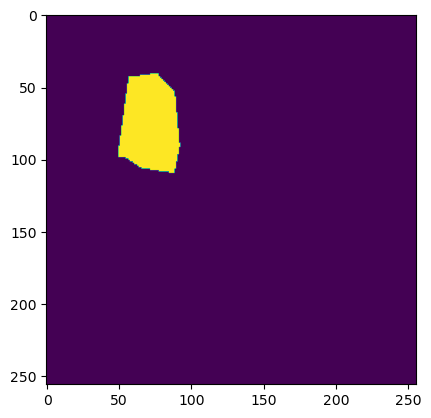